In [1]:
import numpy as np
import gym
env = gym.make("LunarLander-v2")
input_shape = env.observation_space.shape
n_outputs = env.action_space.n
input_shape, n_outputs

((8,), 4)

In [2]:
import tensorflow as tf
from tensorflow import keras

# model that predicts Q-value for each action according to an input state
print(env.reset()[np.newaxis, :])
print(env.action_space.n)
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=input_shape))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(n_outputs))
model(env.reset()[np.newaxis, :])

/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resam

[[ 0.00533113  1.4106328   0.5399748  -0.01277645 -0.0061707  -0.12231229
   0.          0.        ]]
4


2022-05-03 16:06:25.164064: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.15245211, -0.25557384, -0.09043654, -0.00858953]],
      dtype=float32)>

In [3]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis, :])
        return np.argmax(Q_values[0])
epsilon_greedy_policy(env.reset())

0

In [10]:
from collections import deque

# el: state, action, reward, next_state, done
replay_buffer = deque(maxlen=2000)

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    experiences = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [np.array([exp[col] for exp in experiences]) for col in range(5)]
    return states, actions, rewards, next_states, dones

# replay_buffer = [[0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14]]
# sample_experiences(2)

(array([10,  5]),
 array([11,  6]),
 array([12,  7]),
 array([13,  8]),
 array([14,  9]))

In [17]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    obs, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, obs, done))
    return obs, reward, done, info

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [24:38<00:00,  1.97s/it]

-357.13935431215975 190.29114724718954 -1341.4294567761463 18.40714374846098


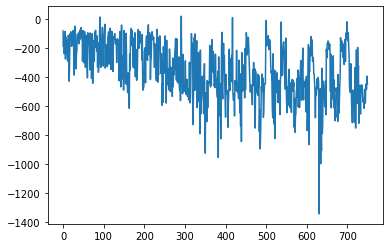

In [26]:
# training
from tqdm import tqdm
import matplotlib.pyplot as plt

batch_size = 32
discount_factor = 0.97
optimizer = keras.optimizers.Adam(0.001)
loss_fn = keras.losses.mean_squared_error
n_episodes = 750
n_steps = 200

def training_step(batch_size):
    states, actions, rewards, next_states, dones = sample_experiences(batch_size)
    next_Q_values = model.predict(next_states)
    max_next_Q_values = tf.reduce_max(next_Q_values, axis=1)
    target_Q_values = rewards + (1 - dones) * discount_factor * max_next_Q_values
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(mask * all_Q_values, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(Q_values, target_Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

def train():
    episode_rewards = []
    for episode in tqdm(range(n_episodes)):
        obs = env.reset()
        step_reward = 0
        for step in range(n_steps):
            eps = max(1 - episode / 500, 0.01)
            obs, reward, done, info = play_one_step(env, obs, eps)
            step_reward += reward
            if done:
                break
        episode_rewards.append(step_reward)
        if episode > 50:
            training_step(batch_size)
    return episode_rewards
episode_rewards = train()
print(np.mean(episode_rewards), np.std(episode_rewards), np.min(episode_rewards), np.max(episode_rewards))
#-359.2941391120138 219.35082075916458 -1486.1583193369427 98.2295202449274

plt.plot(episode_rewards)

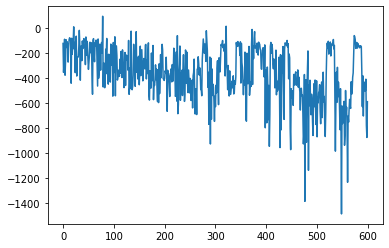